# LOPF using the Zonal Network

PyPSA-GB can model the GB power system  by solving a network constrained Linear Optimal Power Flow (LOPF) problem. This notebook shows the example application of a future 3 day period.

In [1]:
import os
import sys
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
root_path = os.environ.get('PROJECT_SRC')
src_path = os.path.join(root_path, 'PyPSA-GB')

# amended by KO
# original code is os.chdir.(src_path)
if src_path and src_path not in sys.path:
    sys.path.append(src_path)

# Crucial step: Change CWD so relative paths resolve correctly
if os.path.isdir(src_path):
    os.chdir(src_path)
    print(f"Current Working Directory set to: {os.getcwd()}")

Current Working Directory set to: C:\Users\bsko6\OneDrive - Loughborough University\GitHub\PyPSA-GB\PyPSA-GB


In [2]:
import pypsa
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
plt.style.use('ggplot')
import pandas as pd
import cartopy.crs as ccrs
import gurobipy

import data_reader_writer

## Setting up simulation

Set the required inputs for the LOPF: the start, end and year of simulation, and the timestep.

In [3]:
# write csv files for import
start = '2050-06-04 00:00:00'
end = '2050-06-06 23:30:00'
# year of simulation
year = int(start[0:4])
# time step as fraction of hour
time_step = 1.

Choose from one of the National Grid Future Energy Scenarios.

In [4]:
# scenario = 'Leading The Way'
scenario = 'Consumer Transformation'
# scenario = 'System Transformation'
# scenario = 'Steady Progression'

Choose a baseline year (from 2010-2020). The baseline year determines which historical load profile and weather dataset is used for the future year modelled. The National Grid FES modellers used 2012 as their baseline year.

In [5]:
year_baseline = 2014

Here we modify the network argument to choose the zonal model.

In [6]:
networkmodel = 'Zonal'

In [7]:
data_reader_writer.data_writer(start, end, time_step, year, demand_dataset='eload', year_baseline=year_baseline,
                               scenario=scenario, FES=2022, networkmodel=networkmodel, P2G=True)

c:\Users\bsko6\.conda\envs\PyPSA-GB\Lib\encodings\unicode_escape.py:26: DeprecationWarning:

invalid escape sequence '\F'

c:\Users\bsko6\.conda\envs\PyPSA-GB\Lib\encodings\unicode_escape.py:26: DeprecationWarning:

invalid escape sequence '\F'

c:\Users\bsko6\.conda\envs\PyPSA-GB\Lib\encodings\unicode_escape.py:26: DeprecationWarning:

invalid escape sequence '\F'

c:\Users\bsko6\.conda\envs\PyPSA-GB\Lib\encodings\unicode_escape.py:26: DeprecationWarning:

invalid escape sequence '\F'

C:\Users\bsko6\OneDrive - Loughborough University\GitHub\PyPSA-GB\PyPSA-GB\generators.py:655: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True  True  True ...  True  True  True]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.

C:\Users\bsko6\OneDrive - Loughborough University\GitHub\PyPSA-GB\PyPSA-GB\generators.py:674: FutureWarning:

Setting an item of incompatible dtype is deprecated an

In [9]:
network = pypsa.Network()
network.import_from_csv_folder('LOPF_data')

INFO:pypsa.networks:Applying weightings to all columns of `snapshot_weightings`
       'Bri-Cha-Min', 'Bro', 'Bro-Nes', 'Eas-Cas', 'Eas-Rai-Sou', 'Fai-Hea',
       'Har', 'Hol', 'Isl-Man', 'Isl-dem', 'Kyl-Rhe', 'Las-Sou', 'May', 'Mor',
       'Mul-Gal', 'Mul-Kin', 'NE-Jer', 'Nes-Dun', 'Nor-Ron-Fir', 'Pem', 'Pen',
       'Pen-Fir-Dee', 'Pen-Fir-Sha', 'Rai-Isl', 'Ram-Isl', 'Sou-Jer',
       'Sou-Min-Jer', 'St-Dav-Hea', 'St-Mar', 'Str-Lou', 'Str-Sou', 'Tir',
       'Tor-Hea', 'Wav-Hub', 'Wes-Ang-Dem-Mor', 'Wes-Cas', 'Wes-Fir',
       'Wes-Heb', 'Wes-Isl', 'Wes-Lew', 'Wes-Ork', 'Wes-Sou'],
      dtype='object', name='Generator') for attribute p_max_pu of Generator are not in main components dataframe generators
       'Interconnector Lovedean', 'Interconnector Neilston',
       'Interconnector Sellindge'],
      dtype='object', name='Generator') for attribute p_min_pu of Generator are not in main components dataframe generators
INFO:pypsa.io:Imported network LOPF_data has buses, generators

Lines need to be scaled up to accomadate for future generation, and specific analysis will be done on this in a later notebook.
Note: interconnects are links in future, so don't need to be selective here (as was required in historical simulation).

In [10]:
contingency_factor = 4
network.links.p_nom *= contingency_factor

In [11]:
network.optimize(network.snapshots, solver_name="gurobi", solver_options={"Threads": 32, "Method": 2})

Index(['Z10,Z8', 'Z11,Z10', 'Z11,Z9', 'Z12,Z10', 'Z12,Z11', 'Z13,Z11',
       'Z13,Z12', 'Z14,Z12', 'Z15,Z12', 'Z15,Z14', 'Z16,Z13', 'Z16,Z14',
       'Z16,Z15', 'Z17,Z13', 'Z17,Z16', 'Z1_3,Z1_1', 'Z1_3,Z1_2', 'Z1_4,Z1_1',
       'Z1_4,Z1_2', 'Z1_4,Z1_3', 'Z2,Z1_3', 'Z2,Z1_4', 'Z3,Z2', 'Z4,Z3',
       'Z5,Z3', 'Z6,Z5', 'Z7,Z2', 'Z7,Z6', 'Z8,Z7', 'Z9,Z3', 'Z9,Z7', 'Z9,Z8'],
      dtype='object', name='Link')


Index(['Z10', 'Z11', 'Z12', 'Z13', 'Z14', 'Z15', 'Z16', 'Z17', 'Z1_1', 'Z1_2',
       'Z1_3', 'Z1_4', 'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9'],
      dtype='object', name='Bus')
Index(['West Burton', 'Hywind Scotland Pilot Park (Hywind 2) Demonstrator',
       'Beatrice Demonstrator', 'Burbo Bank',
       'Gunfleet Sands - (Demo) Extension', 'Gunfleet Sands II',
       'Gunfleet Sands Offshore Wind Scheme', 'Inner Dowsing', 'Kentish Flats',
       'Lynn',
       ...
       'Unmet Load Z1_3', 'Unmet Load Z1_4', 'Unmet Load Z2', 'Unmet Load Z3',
       'Unmet Load Z4', 'Unmet Load Z5', 'Unmet Load Z6', 'Unmet Load Z7',
       'Unmet Load Z8', 'Unmet Load Z9'],
      dtype='object', name='Generator', length=2427)
Index(['Interconnector Deeside', 'Interconnector Kemsley',
       'Interconnector Lovedean', 'Interconnector Neilston',
       'Interconnector Sellindge'],
      dtype='object', name='Generator')
Index(['Ald Rac', 'Arn', 'Bar', 'Bar-Bri-Cha', 'Ber', 'Big Rus', 'Bla',
     

Set parameter TokenServer to value "gurobi.lboro.ac.uk"


INFO:gurobipy:Set parameter TokenServer to value "gurobi.lboro.ac.uk"


Read LP format model from file C:\Users\bsko6\AppData\Local\Temp\linopy-problem-7bl_0c1u.lp


INFO:gurobipy:Read LP format model from file C:\Users\bsko6\AppData\Local\Temp\linopy-problem-7bl_0c1u.lp


Reading time = 1.26 seconds


INFO:gurobipy:Reading time = 1.26 seconds


obj: 742506 rows, 195192 columns, 1295208 nonzeros


INFO:gurobipy:obj: 742506 rows, 195192 columns, 1295208 nonzeros


Set parameter Threads to value 32


INFO:gurobipy:Set parameter Threads to value 32


Set parameter Method to value 2


INFO:gurobipy:Set parameter Method to value 2


Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: 13th Gen Intel(R) Core(TM) i5-1335U, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-1335U, instruction set [SSE2|AVX|AVX2]


Thread count: 10 physical cores, 12 logical processors, using up to 32 threads


INFO:gurobipy:Thread count: 10 physical cores, 12 logical processors, using up to 32 threads


INFO:gurobipy:


INFO:gurobipy:Warning: Thread count (32) is larger than processor count (12)


         Reduce the value of the Threads parameter to improve performance


INFO:gurobipy:         Reduce the value of the Threads parameter to improve performance


INFO:gurobipy:


INFO:gurobipy:


Non-default parameters:


INFO:gurobipy:Non-default parameters:


Method  2


INFO:gurobipy:Method  2


Threads  32


INFO:gurobipy:Threads  32


INFO:gurobipy:


Optimize a model with 742506 rows, 195192 columns and 1295208 nonzeros


INFO:gurobipy:Optimize a model with 742506 rows, 195192 columns and 1295208 nonzeros


Model fingerprint: 0x9aabbc22


INFO:gurobipy:Model fingerprint: 0x9aabbc22


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [7e-01, 1e+00]


INFO:gurobipy:  Matrix range     [7e-01, 1e+00]


  Objective range  [1e+00, 1e+09]


INFO:gurobipy:  Objective range  [1e+00, 1e+09]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [5e-05, 5e+12]


INFO:gurobipy:  RHS range        [5e-05, 5e+12]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 734592 rows and 167782 columns


INFO:gurobipy:Presolve removed 734592 rows and 167782 columns


Presolve time: 0.60s


INFO:gurobipy:Presolve time: 0.60s


Presolved: 7914 rows, 27836 columns, 48980 nonzeros


INFO:gurobipy:Presolved: 7914 rows, 27836 columns, 48980 nonzeros


INFO:gurobipy:


Ordering time: 0.04s


INFO:gurobipy:Ordering time: 0.04s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 1.552e+04


INFO:gurobipy: AA' NZ     : 1.552e+04


 Factor NZ  : 2.330e+05 (roughly 16 MB of memory)


INFO:gurobipy: Factor NZ  : 2.330e+05 (roughly 16 MB of memory)


 Factor Ops : 1.864e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.864e+07 (less than 1 second per iteration)


 Threads    : 32


INFO:gurobipy: Threads    : 32


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.14400053e+23 -1.87332956e+24  6.00e+10 1.61e+09  7.53e+19     1s


INFO:gurobipy:   0   1.14400053e+23 -1.87332956e+24  6.00e+10 1.61e+09  7.53e+19     1s


   1   1.07208333e+23 -9.43932581e+23  5.55e+10 1.44e+09  6.99e+19     1s


INFO:gurobipy:   1   1.07208333e+23 -9.43932581e+23  5.55e+10 1.44e+09  6.99e+19     1s


   2   1.00970075e+23 -1.71244399e+24  5.16e+10 1.16e+09  6.90e+19     1s


INFO:gurobipy:   2   1.00970075e+23 -1.71244399e+24  5.16e+10 1.16e+09  6.90e+19     1s


   3   8.47979636e+22 -2.94290346e+24  4.19e+10 4.94e+08  7.03e+19     1s


INFO:gurobipy:   3   8.47979636e+22 -2.94290346e+24  4.19e+10 4.94e+08  7.03e+19     1s


   4   6.56196890e+22 -2.97993504e+24  3.10e+10 3.15e+08  6.71e+19     1s


INFO:gurobipy:   4   6.56196890e+22 -2.97993504e+24  3.10e+10 3.15e+08  6.71e+19     1s


   5   5.43487405e+22 -1.26107305e+24  2.49e+10 1.89e+08  4.69e+19     1s


INFO:gurobipy:   5   5.43487405e+22 -1.26107305e+24  2.49e+10 1.89e+08  4.69e+19     1s


   6   4.34790933e+22 -4.55565800e+23  1.92e+10 1.01e+08  3.23e+19     1s


INFO:gurobipy:   6   4.34790933e+22 -4.55565800e+23  1.92e+10 1.01e+08  3.23e+19     1s


   7   2.88157754e+22 -9.36651620e+22  1.20e+10 2.83e+07  1.93e+19     1s


INFO:gurobipy:   7   2.88157754e+22 -9.36651620e+22  1.20e+10 2.83e+07  1.93e+19     1s


   8   3.28348302e+21 -2.69858472e+22  1.19e+09 1.93e+06  2.31e+18     1s


INFO:gurobipy:   8   3.28348302e+21 -2.69858472e+22  1.19e+09 1.93e+06  2.31e+18     1s


   9   7.33860953e+20 -5.42252841e+21  2.41e+08 3.81e+05  4.78e+17     1s


INFO:gurobipy:   9   7.33860953e+20 -5.42252841e+21  2.41e+08 3.81e+05  4.78e+17     1s


  10   6.63301602e+19 -5.05421121e+20  1.85e+07 3.61e+04  3.85e+16     1s


INFO:gurobipy:  10   6.63301602e+19 -5.05421121e+20  1.85e+07 3.61e+04  3.85e+16     1s


  11   2.61105851e+17 -5.74953645e+17  6.10e+04 2.92e+01  1.08e+14     1s


INFO:gurobipy:  11   2.61105851e+17 -5.74953645e+17  6.10e+04 2.92e+01  1.08e+14     1s


  12   3.57672978e+16 -8.74729350e+16  8.22e+03 3.92e-02  1.44e+13     1s


INFO:gurobipy:  12   3.57672978e+16 -8.74729350e+16  8.22e+03 3.92e-02  1.44e+13     1s


  13   8.27166871e+15 -5.71499665e+16  1.74e+03 3.77e-03  3.49e+12     1s


INFO:gurobipy:  13   8.27166871e+15 -5.71499665e+16  1.74e+03 3.77e-03  3.49e+12     1s


  14   1.96924659e+15 -2.80642089e+16  3.35e+02 5.68e-03  8.74e+11     1s


INFO:gurobipy:  14   1.96924659e+15 -2.80642089e+16  3.35e+02 5.68e-03  8.74e+11     1s


  15   4.85180876e+14 -9.54763959e+15  9.37e+01 2.44e-04  2.32e+11     1s


INFO:gurobipy:  15   4.85180876e+14 -9.54763959e+15  9.37e+01 2.44e-04  2.32e+11     1s


  16   1.61853420e+14 -3.41962128e+15  3.82e+01 7.82e-05  7.50e+10     1s


INFO:gurobipy:  16   1.61853420e+14 -3.41962128e+15  3.82e+01 7.82e-05  7.50e+10     1s


  17   1.60437565e+13 -4.57560567e+14  4.24e+00 1.62e-05  8.84e+09     1s


INFO:gurobipy:  17   1.60437565e+13 -4.57560567e+14  4.24e+00 1.62e-05  8.84e+09     1s


  18   4.99423692e+10 -4.33137450e+12  4.79e-10 3.86e-06  7.87e+07     1s


INFO:gurobipy:  18   4.99423692e+10 -4.33137450e+12  4.79e-10 3.86e-06  7.87e+07     1s


  19   4.65127123e+08 -2.79052429e+10  2.11e-10 2.86e-06  5.10e+05     1s


INFO:gurobipy:  19   4.65127123e+08 -2.79052429e+10  2.11e-10 2.86e-06  5.10e+05     1s


  20   3.04480943e+08 -7.98910041e+09  2.33e-10 2.86e-06  1.49e+05     1s


INFO:gurobipy:  20   3.04480943e+08 -7.98910041e+09  2.33e-10 2.86e-06  1.49e+05     1s


  21   1.76992102e+08 -2.55093266e+09  2.04e-10 2.88e-06  4.90e+04     1s


INFO:gurobipy:  21   1.76992102e+08 -2.55093266e+09  2.04e-10 2.88e-06  4.90e+04     1s


  22   1.53047039e+08 -1.64816001e+09  1.29e-10 2.17e-06  3.24e+04     1s


INFO:gurobipy:  22   1.53047039e+08 -1.64816001e+09  1.29e-10 2.17e-06  3.24e+04     1s


  23   1.12425239e+08 -9.50506825e+08  1.33e-10 2.65e-06  1.91e+04     1s


INFO:gurobipy:  23   1.12425239e+08 -9.50506825e+08  1.33e-10 2.65e-06  1.91e+04     1s


  24   1.02866167e+08 -8.32921293e+08  1.13e-10 2.02e-06  1.68e+04     1s


INFO:gurobipy:  24   1.02866167e+08 -8.32921293e+08  1.13e-10 2.02e-06  1.68e+04     1s


  25   8.00996170e+07 -3.95611163e+08  9.09e-11 1.91e-06  8.54e+03     1s


INFO:gurobipy:  25   8.00996170e+07 -3.95611163e+08  9.09e-11 1.91e-06  8.54e+03     1s


  26   6.20666995e+07 -1.95827052e+08  6.75e-11 1.91e-06  4.63e+03     1s


INFO:gurobipy:  26   6.20666995e+07 -1.95827052e+08  6.75e-11 1.91e-06  4.63e+03     1s


  27   3.04557210e+07 -6.31185072e+07  1.97e-10 1.91e-06  1.68e+03     1s


INFO:gurobipy:  27   3.04557210e+07 -6.31185072e+07  1.97e-10 1.91e-06  1.68e+03     1s


  28   2.57495934e+07 -3.06278193e+07  1.74e-10 1.91e-06  1.01e+03     1s


INFO:gurobipy:  28   2.57495934e+07 -3.06278193e+07  1.74e-10 1.91e-06  1.01e+03     1s


  29   1.96880535e+07 -1.98427404e+07  3.30e-10 1.91e-06  7.10e+02     1s


INFO:gurobipy:  29   1.96880535e+07 -1.98427404e+07  3.30e-10 1.91e-06  7.10e+02     1s


  30   1.68630887e+07 -9.87440075e+06  5.95e-10 1.91e-06  4.80e+02     1s


INFO:gurobipy:  30   1.68630887e+07 -9.87440075e+06  5.95e-10 1.91e-06  4.80e+02     1s


  31   1.30117543e+07  1.53157871e+06  5.76e-10 1.91e-06  2.06e+02     1s


INFO:gurobipy:  31   1.30117543e+07  1.53157871e+06  5.76e-10 1.91e-06  2.06e+02     1s


  32   9.77065603e+06  5.62669702e+06  1.00e-09 1.91e-06  7.44e+01     1s


INFO:gurobipy:  32   9.77065603e+06  5.62669702e+06  1.00e-09 1.91e-06  7.44e+01     1s


  33   8.55453941e+06  6.66135559e+06  1.83e-09 2.07e-06  3.40e+01     1s


INFO:gurobipy:  33   8.55453941e+06  6.66135559e+06  1.83e-09 2.07e-06  3.40e+01     1s


  34   8.35453398e+06  7.01811614e+06  2.09e-09 1.91e-06  2.40e+01     1s


INFO:gurobipy:  34   8.35453398e+06  7.01811614e+06  2.09e-09 1.91e-06  2.40e+01     1s


  35   8.26891670e+06  7.36583453e+06  2.36e-09 1.91e-06  1.62e+01     1s


INFO:gurobipy:  35   8.26891670e+06  7.36583453e+06  2.36e-09 1.91e-06  1.62e+01     1s


  36   8.10800362e+06  7.50851358e+06  2.87e-09 1.95e-06  1.08e+01     1s


INFO:gurobipy:  36   8.10800362e+06  7.50851358e+06  2.87e-09 1.95e-06  1.08e+01     1s


  37   7.95662903e+06  7.66316952e+06  1.26e-08 1.93e-06  5.27e+00     1s


INFO:gurobipy:  37   7.95662903e+06  7.66316952e+06  1.26e-08 1.93e-06  5.27e+00     1s


  38   7.83286237e+06  7.76650916e+06  1.29e-08 2.86e-06  1.19e+00     1s


INFO:gurobipy:  38   7.83286237e+06  7.76650916e+06  1.29e-08 2.86e-06  1.19e+00     1s


  39   7.81312933e+06  7.80140299e+06  6.01e-08 2.86e-06  2.11e-01     2s


INFO:gurobipy:  39   7.81312933e+06  7.80140299e+06  6.01e-08 2.86e-06  2.11e-01     2s


  40   7.80698319e+06  7.80542197e+06  1.43e-06 2.86e-06  2.80e-02     2s


INFO:gurobipy:  40   7.80698319e+06  7.80542197e+06  1.43e-06 2.86e-06  2.80e-02     2s


  41   7.80613870e+06  7.80611442e+06  3.21e-06 2.86e-06  4.36e-04     2s


INFO:gurobipy:  41   7.80613870e+06  7.80611442e+06  3.21e-06 2.86e-06  4.36e-04     2s


  42   7.80612825e+06  7.80612825e+06  9.55e-10 1.91e-06  5.85e-09     2s


INFO:gurobipy:  42   7.80612825e+06  7.80612825e+06  9.55e-10 1.91e-06  5.85e-09     2s


INFO:gurobipy:


Barrier solved model in 42 iterations and 1.60 seconds (0.75 work units)


INFO:gurobipy:Barrier solved model in 42 iterations and 1.60 seconds (0.75 work units)


Optimal objective 7.80612825e+06


INFO:gurobipy:Optimal objective 7.80612825e+06


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2062 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:    2062 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:


    6963 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:    6963 PPushes remaining with PInf 0.0000000e+00                 2s


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.1174174e-12      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.1174174e-12      2s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    8858    7.8061282e+06   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:    8858    7.8061282e+06   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 8858 iterations and 2.10 seconds (1.05 work units)


INFO:gurobipy:Solved in 8858 iterations and 2.10 seconds (1.05 work units)


Optimal objective  7.806128247e+06


INFO:gurobipy:Optimal objective  7.806128247e+06
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 195192 primals, 742506 duals
Objective: 7.81e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

## Running the optimisation

## Power output by generation type

Group the generators by the carrier, and print their summed power outputs over the simulation period.

In [12]:
p_by_carrier = network.generators_t.p.groupby(
    network.generators.carrier, axis=1).sum()

storage_by_carrier = network.storage_units_t.p.groupby(
    network.storage_units.carrier, axis=1).sum()

# to show on graph set the negative storage values to zero
storage_by_carrier[storage_by_carrier < 0] = 0

p_by_carrier = pd.concat([p_by_carrier, storage_by_carrier], axis=1)

if networkmodel == 'Zonal':
    boundary = pd.read_csv('../data/network/ZonesBasedGBsystem/network/links.csv')['name'].tolist()
    imp = network.links_t.p0.copy().drop(columns=boundary)
    imp[imp < 0] = 0
    imp['Interconnectors Import'] = imp.sum(axis=1)
    interconnector_import = imp[['Interconnectors Import']]

    p_by_carrier = pd.concat([p_by_carrier, interconnector_import], axis=1)

    exp = network.links_t.p0.copy().drop(columns=boundary)
    exp[exp > 0] = 0
    exp['Interconnectors Export'] = exp.sum(axis=1)
    interconnector_export = exp[['Interconnectors Export']]

# group biomass stuff
p_by_carrier['Biomass'] = (
    p_by_carrier['Biomass (dedicated)'] + p_by_carrier['Biomass (co-firing)'])

# rename the hydro bit
p_by_carrier = p_by_carrier.rename(
    columns={'Large Hydro': 'Hydro'})
p_by_carrier = p_by_carrier.rename(
    columns={'Interconnector': 'Interconnectors Import'})

C:\Users\bsko6\AppData\Local\Temp\ipykernel_29604\3359949882.py:1: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\bsko6\AppData\Local\Temp\ipykernel_29604\3359949882.py:4: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



Graph the power output of the different generation types...

Text(0.5, 0, '')

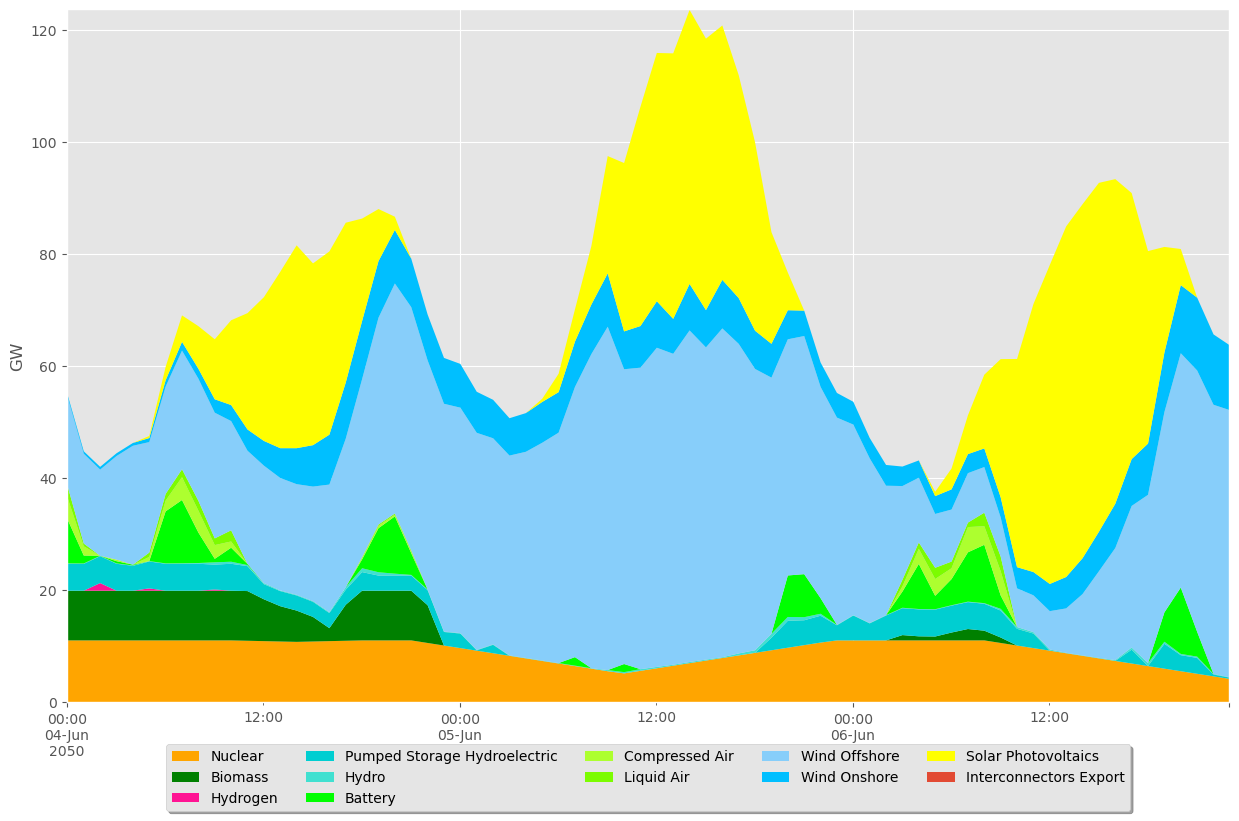

In [13]:
cols = ["Nuclear", 'Biomass',
        'Hydrogen', 'CCS Gas', 'CCS Biomass',
        "Pumped Storage Hydroelectric", 'Hydro',
        'Battery', 'Compressed Air', 'Liquid Air',
        "Wind Offshore", 'Wind Onshore', 'Solar Photovoltaics', 
        'Unmet Load', 'Interconnectors Import'
        ]

p_by_carrier = p_by_carrier[cols]

p_by_carrier.drop(
    (p_by_carrier.max()[p_by_carrier.max() < 50.0]).index,
    axis=1, inplace=True)


colors = {"Coal": "grey",
          "Diesel/Gas oil": "black",
          "Diesel/gas Diesel/Gas oil": "black",
          'Oil': 'black',
          'Unmet Load': 'black',
          'Anaerobic Digestion': 'green',
          'Waste': 'chocolate',
          'Sewage Sludge Digestion': 'green',
          'Landfill Gas': 'green',
          'Biomass (dedicated)': 'green',
          'Biomass (co-firing)': 'green',
          'Biomass': 'green',
          'CCS Biomass': 'darkgreen',
          'Interconnectors Import': 'pink',
          'B6 import': 'pink',
          "Sour gas": "lightcoral",
          "Natural Gas": "lightcoral",
          'CCS Gas': "lightcoral",
          'Hydrogen': "deeppink",
          "Nuclear": "orange",
          'Shoreline Wave': 'aqua',
          'Tidal Barrage and Tidal Stream': 'aqua',
          'Hydro': "turquoise",
          "Large Hydro": "turquoise",
          "Small Hydro": "turquoise",
          "Pumped Storage Hydroelectric": "darkturquoise",
          'Battery': 'lime',
          'Compressed Air': 'greenyellow',
          'Liquid Air': 'lawngreen',
          "Wind Offshore": "lightskyblue",
          'Wind Onshore': 'deepskyblue',
          'Solar Photovoltaics': 'yellow'}

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(p_by_carrier / 1e3).plot(
    kind="area", ax=ax, linewidth=0,
    color=[colors[col] for col in p_by_carrier.columns])

# stacked area plot of negative values, prepend column names with '_' such that they don't appear in the legend
(interconnector_export / 1e3).plot.area(ax=ax, stacked=True, linewidth=0.)
# rescale the y axis
ax.set_ylim([(interconnector_export / 1e3).sum(axis=1).min(), (p_by_carrier / 1e3).sum(axis=1).max()])

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

ax.set_ylabel("GW")

ax.set_xlabel("")

## Plotting network

In [14]:
now = network.snapshots[60]

print("With the linear load flow, there is the following per unit loading:")
loading = network.links_t.p0.loc[now] / network.links.p_nom
loading.describe()

With the linear load flow, there is the following per unit loading:


count    31.000000
mean      0.282223
std       0.669100
min      -1.000000
25%      -0.107858
50%       0.164250
75%       1.000000
max       1.000000
dtype: float64

c:\Users\alyden\Anaconda3\envs\PyPSA-GB2\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



(<matplotlib.collections.PatchCollection at 0x1ed21b19b80>,
 <matplotlib.collections.LineCollection at 0x1ed22a7f560>)

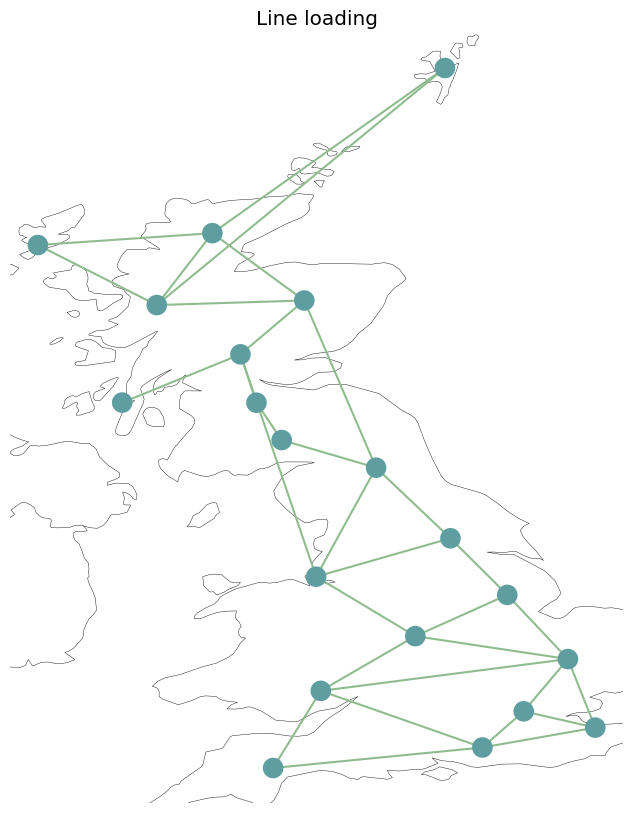

In [15]:

fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(20, 10)

network.plot(ax=ax, line_colors=abs(loading), line_cmap=plt.cm.jet, title="Line loading")

c:\Users\bsko6\.conda\envs\PyPSA-GB\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



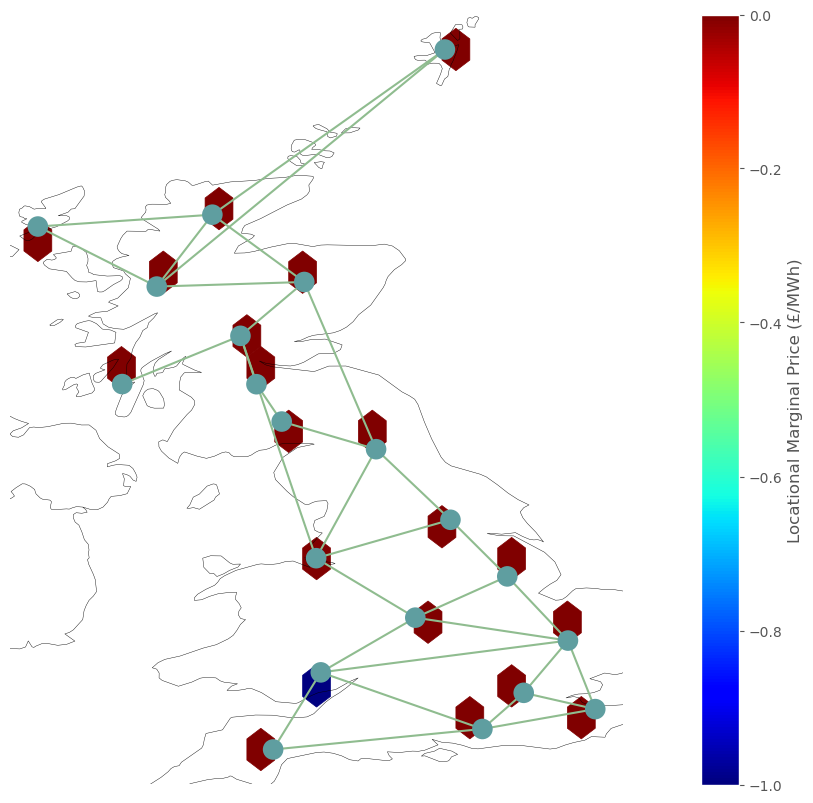

In [15]:
now = network.snapshots[60]
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(20, 10)

network.plot(ax=ax, line_widths=pd.Series(0.5, network.links.index))
plt.hexbin(network.buses.x, network.buses.y,
           gridsize=20,
           C=network.buses_t.marginal_price.loc[now],
           cmap=plt.cm.jet)

# for some reason the colorbar only works with graphs plt.plot
# and must be attached plt.colorbar

cb = plt.colorbar()
cb.set_label('Locational Marginal Price (£/MWh)')